In [ ]:
# bidirectional model LSTM
  # All necessary imports.
  # Dataset loading and initial inspection.
  # Text preprocessing and tokenization.
  # Vocabulary building.
  # Sequence length analysis (for context, though I'll use a fixed max_len=200 based on lec3 previous code execution).
  # Sequence encoding and padding.
  # Custom PyTorch Dataset.
  # Data splitting (train/validation).
  # PyTorch DataLoaders.
  # The BidirectionalSentimentLSTM model definition.
  # Model initialization and device placement.
  # Loss function and optimizer definition.
  # Training function (train).
  # Evaluation function (evaluate).
  # The main training loop.
  # Plotting of training/validation metrics.
  # Final evaluation on the test set
  # A function to predict sentiment on new text inputs.
  # Saving the trained model.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re

In [ ]:
# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize
print("Checking NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("NLTK data check complete.")



Checking NLTK data...
NLTK data check complete.


In [ ]:
# For loading datasets
!pip install datasets
from datasets import load_dataset

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")


In [ ]:
# Load the dataset
dataset = load_dataset("imdb")

# Get train and test data
train_data = dataset["train"]
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Display sample data
print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f"Sample review (text): {train_data[0]['text'][:100]}...")
print(f"Sample label (0=negative, 1=positive): {train_data[0]['label']}")


Dataset loaded! Total training examples: 25000
Sample review (text): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Sample label (0=negative, 1=positive): 0


In [ ]:
#Data Cleaning and Tokenization
def preprocess_text(text):
    """Clean and tokenize the text"""
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    return tokens


In [ ]:
print("Starting data preprocessing...")


Starting data preprocessing...


In [ ]:
# Process training data
train_reviews = []
train_labels = []

In [ ]:
for sample in tqdm(train_data):
    # Labels are already integers (0=negative, 1=positive)
    label_int = sample['label']
    train_labels.append(label_int)
    # Preprocess text
    tokens = preprocess_text(sample['text'])
    train_reviews.append(tokens)

100%|██████████| 25000/25000 [00:39<00:00, 626.67it/s]


In [ ]:
# Process testing data
test_reviews = []
test_labels = []

In [ ]:
for sample in tqdm(test_data, desc="Processing test data"):
    label_int = sample['label']
    test_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    test_reviews.append(tokens)

Processing test data: 100%|██████████| 25000/25000 [00:18<00:00, 1353.00it/s]


In [ ]:
print(f"Data preprocessing complete! Example tokenized review: {train_reviews[0][:15]}...")
print(f"Data preprocessing complete! Example tokenized label: {train_labels[0]}...")

Data preprocessing complete! Example tokenized review: ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']...
Data preprocessing complete! Example tokenized label: 0...


In [ ]:
#Vocabulary Building
def build_vocab(reviews, max_words=10000):
    """Build a vocabulary of the most common words"""
    word_count = Counter()

    # Count all words
    for review in reviews:
        word_count.update(review)

    # Select most common words
    most_common = word_count.most_common(max_words - 2)  # -2 for <UNK> and <PAD>
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}

    # Add special tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab

print("Building vocabulary...")
# Build vocabulary from training data
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)
print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(vocab.items())[:10]}")

# Create a reverse mapping for decoding
idx_to_word = {idx: word for word, idx in vocab.items()}


Building vocabulary...
Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9), ('this', 10), ('i', 11)]


In [ ]:
#Sequence Encoding and Padding
# Analyze review lengths to determine a reasonable max_len
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)
print(f"Maximum review length: {max(review_lengths)}")
print(f"Mean review length: {np.mean(review_lengths):.2f}")
print(f"Median review length: {np.median(review_lengths)}")
print(f"95th percentile length: {np.percentile(review_lengths, 95):.0f}")

# let's use max_len = 200
chosen_max_len = 200

print(f"Encoding reviews with max_len: {chosen_max_len}")

Maximum review length: 2441
Mean review length: 227.81
Median review length: 170.0
95th percentile length: 583
Encoding reviews with max_len: 200


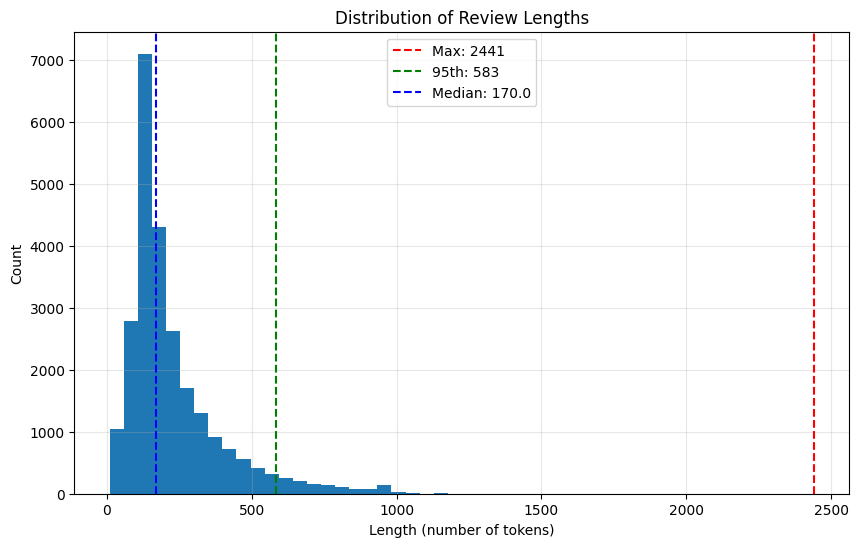

In [ ]:
# Plotting the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def encode_review(review, vocab, max_len):
    """Convert a review to a fixed-length sequence of integers"""
    # Encode words, use <UNK> for unknown words, truncate
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    # Pad sequences to the same length
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    # Ensure no extra tokens if review was exactly max_len or longer
    else:
         encoded = encoded[:max_len] # Explicitly truncate if it was longer

    return encoded


# Encode all reviews using the chosen max_len
train_encoded = [encode_review(review, vocab, chosen_max_len) for review in tqdm(train_reviews, desc="Encoding training data")]
test_encoded = [encode_review(review, vocab, chosen_max_len) for review in tqdm(test_reviews, desc="Encoding test data")]
# Convert to tensors
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

Encoding test data: 100%|██████████| 25000/25000 [00:00<00:00, 40187.58it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...
All sequences are now of length 200


In [ ]:
#Create PyTorch Dataset and DataLoaders
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]
# Create train/validation split
train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_sequences, train_labels_tensor, test_size=0.1, random_state=42
)

In [ ]:
# Create datasets
train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor) # Use the original test data for final evaluation

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"DataLoaders created! Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}, Test batches: {len(test_loader)}")


DataLoaders created! Training batches: 352, Validation batches: 40, Test batches: 391


In [ ]:
#Build Bidirectional Network Architecture
class BidirectionalSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super().__init__()

        self.hidden_dim = hidden_dim # Store hidden_dim
        self.n_layers = n_layers     # Store n_layers

        # Embedding layer
        # padding_idx=0 ensures the padding token's embedding is not updated
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer - Set bidirectional=True
        # batch_first=True means input/output tensors are (batch, seq, feature)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=True, # <--- Changed to True
                            dropout=dropout if n_layers > 1 else 0, # Dropout applied between layers if n_layers > 1
                            batch_first=True)

        # Dropout layer - Applied to the final concatenated hidden state
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        # Input features doubled for bidirectional (forward + backward hidden states)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # <--- Input size changed

    def forward(self, text):
        # text shape: [batch_size, seq_len]

        # Embed the text
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]

        # Pass through LSTM
        # lstm_out shape: [batch_size, seq_len, hidden_dim * 2] (if bidirectional)
        # hidden shape: [n_layers * 2, batch_size, hidden_dim] (if bidirectional) - final hidden state for each layer and direction
        # cell shape: [n_layers * 2, batch_size, hidden_dim] (if bidirectional) - final cell state for each layer and direction
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Use the final hidden states from the last forward and backward layers
        # hidden shape is (num_directions * num_layers, batch, hidden_size)
        # We want the last layer's final hidden state from both directions
        # hidden[-2, :, :] is the final hidden state of the last forward layer
        # hidden[-1, :, :] is the final hidden state of the last backward layer
        # Concatenate these two states along the feature dimension (dim=1)
        final_hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) # [batch_size, hidden_dim * 2]

        # Apply dropout to the concatenated hidden state
        final_hidden = self.dropout(final_hidden)  # [batch_size, hidden_dim * 2]

        # Pass through linear layer to get the raw output scores (logits)
        return self.fc(final_hidden)  # [batch_size, output_dim]

In [ ]:
# Initialize bidirectional model parameters
embedding_dim = 100 # Size of word embeddings
hidden_dim = 256    # Size of the hidden state in each LSTM cell
output_dim = 1      # 1 for binary classification (positive/negative)
n_layers = 2        # Number of stacked bidirectional LSTM layers
dropout = 0.5       # Dropout probability

In [ ]:
model = BidirectionalSentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    dropout=dropout
)

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Bidirectional Model created and moved to {device}!")
print(model)

Bidirectional Model created and moved to cuda!
BidirectionalSentimentLSTM(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
# Define Loss Function and Optimizer
# BCEWithLogitsLoss is stable and combines Sigmoid and BCELoss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with a learning rate

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


In [ ]:
# Training Function
def train(model, iterator, optimizer, criterion):
    """Training function for one epoch"""
    # Set model to training mode (enables dropout)
    model.train()

    # Track loss and accuracy
    epoch_loss = 0
    epoch_acc = 0

    # Iterate over batches with tqdm progress bar
    for batch in tqdm(iterator, desc="Training"):
        # Get batch data and move to device
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        # Zero gradients from the previous step
        optimizer.zero_grad()

        # Forward pass - get raw predictions (logits)
        predictions = model(text).squeeze(1) # Remove dimension of size 1

        # Calculate loss
        loss = criterion(predictions, labels)

        # Calculate accuracy
        # Apply sigmoid to get probabilities, then round to get binary predictions
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float() # Count correct predictions
        accuracy = correct.sum() / len(correct)      # Calculate accuracy for the batch

        # Backward pass - compute gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update running metrics
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()

    # Return average loss and accuracy for the epoch
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# --- Evaluation Function ---
def evaluate(model, iterator, criterion):
    """Evaluation function"""
    # Set model to evaluation mode (disables dropout)
    model.eval()

    # Track loss and accuracy
    epoch_loss = 0
    epoch_acc = 0

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over batches with tqdm progress bar
        for batch in tqdm(iterator, desc="Evaluating"):
            # Get batch data and move to device
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            # Forward pass
            predictions = model(text).squeeze(1)

            # Calculate loss
            loss = criterion(predictions, labels)

            # Calculate accuracy
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float()
            accuracy = correct.sum() / len(correct)

            # Update running metrics
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()

    # Return average loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
#Training Loop
n_epochs = 5

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"\nStarting training for {n_epochs} epochs...")
# Training loop
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    # Train for one epoch
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("\nTraining complete!")


Starting training for 5 epochs...

Epoch 1/5
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.14it/s]


Train Loss: 0.5854 | Train Acc: 68.61%
Val Loss: 0.4616 | Val Acc: 79.38%

Epoch 2/5
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 36.06it/s]


Train Loss: 0.3768 | Train Acc: 83.92%
Val Loss: 0.3665 | Val Acc: 83.91%

Epoch 3/5
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 36.32it/s]


Train Loss: 0.2806 | Train Acc: 88.92%
Val Loss: 0.3677 | Val Acc: 85.86%

Epoch 4/5
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.90it/s]


Train Loss: 0.2229 | Train Acc: 91.61%
Val Loss: 0.3727 | Val Acc: 86.33%

Epoch 5/5
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.93it/s]

Train Loss: 0.1720 | Train Acc: 93.89%
Val Loss: 0.3932 | Val Acc: 85.94%

Training complete!


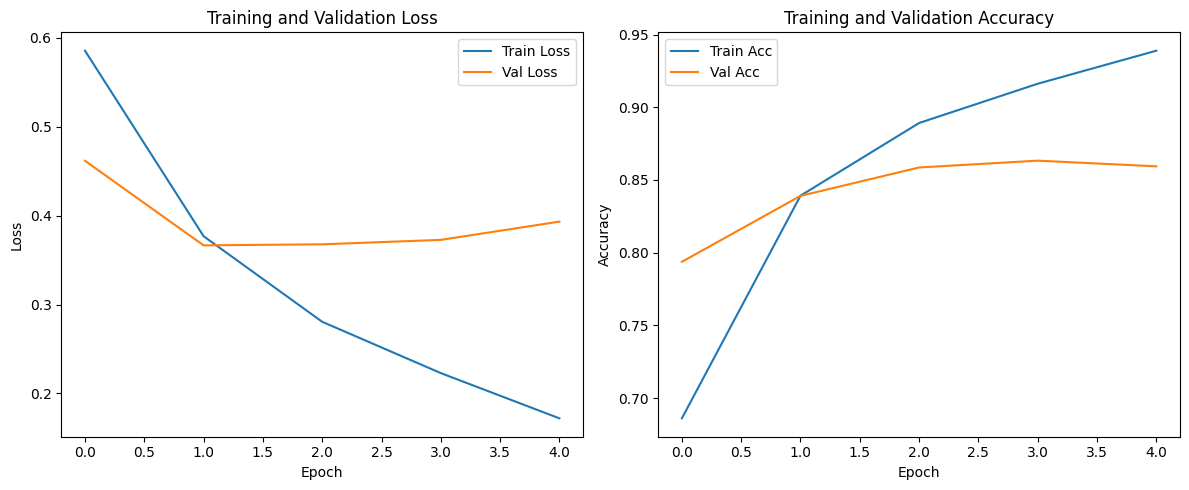

In [ ]:
# --- Plotting Metrics ---
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Evaluate on Test Set ---
print("\nEvaluating model on the test set...")
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


Evaluating model on the test set...


Evaluating: 100%|██████████| 391/391 [00:11<00:00, 35.42it/s]

Test Loss: 0.4264 | Test Acc: 84.81%


In [ ]:
# --- Prediction Function ---
def predict_sentiment(model, text, vocab, max_len=200, device='cpu'):
    """Predict sentiment for a single text input"""
    # Preprocess
    tokens = preprocess_text(text)
    # Encode using the SAME max_len used during training
    encoded = encode_review(tokens, vocab, max_len)
    # Convert to tensor and add batch dimension [1, seq_len]
    tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Get prediction (logits)
    with torch.no_grad():
        prediction = model(tensor).squeeze(1) # Output shape [1]

    # Apply sigmoid to get probability [0, 1]
    probability = torch.sigmoid(prediction).item() # Get scalar value

    # Determine sentiment
    sentiment = "Positive" if probability >= 0.5 else "Negative"

    return probability, sentiment

In [ ]:
print("\nModel predictions on sample reviews:")
sample_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "I was thoroughly disappointed with this film. The story made no sense and the acting was terrible.",
    "It was okay. Nothing special but not terrible either.",
    "Despite some flaws in the plot, the movie had great visual effects and good performances.",
    "A masterpiece of modern cinema. I was captivated from start to finish."
]


Model predictions on sample reviews:


In [ ]:
for review in sample_reviews:
    prob, sent = predict_sentiment(model, review, vocab, max_len=chosen_max_len, device=device)
    print(f"Review: {review[:60]}...") # Print first 60 chars
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)


Review: This movie was absolutely amazing! The acting was superb and...
Sentiment: Positive (probability: 0.9779)
--------------------------------------------------
Review: I was thoroughly disappointed with this film. The story made...
Sentiment: Negative (probability: 0.0082)
--------------------------------------------------
Review: It was okay. Nothing special but not terrible either....
Sentiment: Negative (probability: 0.0221)
--------------------------------------------------
Review: Despite some flaws in the plot, the movie had great visual e...
Sentiment: Positive (probability: 0.9077)
--------------------------------------------------
Review: A masterpiece of modern cinema. I was captivated from start ...
Sentiment: Positive (probability: 0.9876)
--------------------------------------------------


In [ ]:
# Save Model
# Save the model state, vocabulary, and model parameters
model_save_path = 'lstm_bidirectional_sentiment_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'max_len': chosen_max_len, # Save max_len used for encoding
    'model_params': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
        'n_layers': n_layers,
        'dropout': dropout,
        'bidirectional': True # Indicate it's bidirectional
    }}, model_save_path)

print(f"Model saved successfully to {model_save_path}!")

Model saved successfully to lstm_bidirectional_sentiment_model.pt!
